# Grid Square Area Chart

This notebook demonstrates a grid-based visualization where each cell contains a square whose area represents a percentage value. The chart is similar to the McKinsey-style grid charts showing survey responses across age groups.


In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import textwrap

import dartwork_mpl as dm
dm.style.use_preset('scientific')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def plot_grid_square_area(
    data,
    row_labels,
    col_labels,
    highlight_cols=None,
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    row_label_width=None,
    colors=None,
    title=None,
    title_fontsize=None,
    label_fontsize=None,
    value_fontsize=None,
    figsize=None,
    dpi=300
):
    """
    Create a grid-based chart where each cell contains a square whose area represents a percentage value.
    
    Parameters
    ----------
    data : array-like, shape (n_rows, n_cols)
        2D array of percentage values (0-100) for each cell.
    row_labels : list of str
        Labels for each row (left side).
    col_labels : list of str
        Labels for each column (bottom).
    highlight_cols : list of int, optional
        Column indices to highlight with different color. Default is None.
    cell_size : float, optional
        Base size of each cell. Default is 1.0.
    cell_spacing : float, optional
        Spacing between cells as fraction of cell_size. Default is 0.15.
    margin : float, optional
        Margin around the entire grid as fraction of cell_size. Default is 0.1.
    row_label_width : float or None, optional
        Width for row labels in units of cell_size. If None, automatically calculated.
        Text will be wrapped to fit this width. Default is None.
    colors : dict, optional
        Dictionary with keys 'default' and 'highlight' for color specifications.
        Default uses 'dm.blue5' and 'dm.blue3'.
    title : str, optional
        Title for the chart. Default is None.
    title_fontsize : float or None, optional
        Font size for title. If None, uses dm.fs(1).
    label_fontsize : float or None, optional
        Font size for row/column labels. If None, uses dm.fs(0).
    value_fontsize : float or None, optional
        Font size for percentage values. If None, uses dm.fs(-1).
    figsize : tuple of float or None, optional
        Figure size in inches. If None, calculated automatically.
    dpi : int, optional
        DPI for the figure. Default is 300.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure.
    ax : matplotlib.axes.Axes
        The axes containing the plot.
    """
    # Convert data to numpy array
    data = np.array(data)
    n_rows, n_cols = data.shape
    
    # Validate dimensions
    if len(row_labels) != n_rows:
        raise ValueError(f"Number of row_labels ({len(row_labels)}) must match number of rows ({n_rows})")
    if len(col_labels) != n_cols:
        raise ValueError(f"Number of col_labels ({len(col_labels)}) must match number of columns ({n_cols})")
    
    # Default colors
    if colors is None:
        colors = {
            'default': 'dm.blue5',
            'highlight': 'dm.blue3'
        }
    
    # Default font sizes
    if title_fontsize is None:
        title_fontsize = dm.fs(1)
    if label_fontsize is None:
        label_fontsize = dm.fs(0)
    if value_fontsize is None:
        value_fontsize = dm.fs(-1)
    
    # Handle highlight_cols
    if highlight_cols is None:
        highlight_cols = []
    highlight_cols = set(highlight_cols)
    
    # Calculate grid dimensions
    # Total width = n_cols * cell_size + (n_cols - 1) * cell_spacing * cell_size + 2 * margin * cell_size
    # Total height = n_rows * cell_size + (n_rows - 1) * cell_spacing * cell_size + 2 * margin * cell_size
    # Plus space for labels
    spacing = cell_spacing * cell_size
    
    # Estimate label widths/heights (approximate)
    # Left margin for row labels
    if row_label_width is None:
        # Default: estimate based on longest label, but limit to reasonable width
        max_label_len = max(len(label) for label in row_labels)
        row_label_width = min(max_label_len * 0.012 * cell_size, 0.25 * cell_size)  # Limit width
        row_label_width = max(row_label_width, 0.2 * cell_size)  # Minimum width
    else:
        # Use provided width (in same units as cell_size)
        row_label_width = row_label_width * cell_size
    
    # Top margin for column labels
    col_label_height = 0.15
    
    # Top margin for title (above column labels)
    title_height = 0.2 if title else 0.05
    
    grid_width = n_cols * cell_size + (n_cols - 1) * spacing
    grid_height = n_rows * cell_size + (n_rows - 1) * spacing
    
    total_width = grid_width + 2 * margin * cell_size + row_label_width
    total_height = grid_height + 2 * margin * cell_size + col_label_height + title_height
    
    # Calculate figure size if not provided
    if figsize is None:
        # Maintain aspect ratio approximately
        aspect_ratio = total_width / total_height
        base_size = 14  # cm
        if aspect_ratio > 1:
            fig_width = base_size * aspect_ratio
            fig_height = base_size
        else:
            fig_width = base_size
            fig_height = base_size / aspect_ratio
        figsize = (dm.cm2in(fig_width), dm.cm2in(fig_height))
    
    # Create figure and axis
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111)
    
    # Grid origin (bottom-left corner of grid)
    grid_x0 = margin * cell_size + row_label_width
    grid_y0 = margin * cell_size  # Bottom margin only (column labels are at top)
    
    # Draw cells and squares
    for i in range(n_rows):
        for j in range(n_cols):
            # Cell position (bottom-left corner)
            cell_x = grid_x0 + j * (cell_size + spacing)
            cell_y = grid_y0 + (n_rows - 1 - i) * (cell_size + spacing)  # Top row first
            
            # Determine color
            is_highlight = j in highlight_cols
            cell_color = colors['highlight'] if is_highlight else colors['default']
            
            # Draw outer square (100% reference - cell boundary)
            outer_square = Rectangle(
                (cell_x, cell_y),
                cell_size,
                cell_size,
                facecolor='none',
                edgecolor='dm.gray8',
                linewidth=0.5,
                zorder=1
            )
            ax.add_patch(outer_square)
            
            # Calculate inner square size based on percentage
            # Area of square = (percentage / 100) * cell_area
            # Side of square = sqrt(area) = sqrt(percentage / 100) * cell_size
            percentage = data[i, j]
            square_side = np.sqrt(percentage / 100.0) * cell_size
            
            # Center the square in the cell
            square_x = cell_x + (cell_size - square_side) / 2
            square_y = cell_y + (cell_size - square_side) / 2
            
            # Draw inner square (proportional to percentage)
            inner_square = Rectangle(
                (square_x, square_y),
                square_side,
                square_side,
                facecolor=cell_color,
                edgecolor='white',
                linewidth=0.5,
                zorder=2
            )
            ax.add_patch(inner_square)
            
            # Add percentage value text (centered in cell)
            ax.text(
                cell_x + cell_size / 2,
                cell_y + cell_size / 2,
                f"{int(percentage)}%",
                ha='center',
                va='center',
                fontsize=value_fontsize,
                color='dm.gray9',
                weight=dm.fw(0),
                zorder=3
            )
    
    # Add row labels (left side) with text wrapping
    for i in range(n_rows):
        cell_y = grid_y0 + (n_rows - 1 - i) * (cell_size + spacing)
        label_y = cell_y + cell_size / 2
        
        # Wrap text based on character width estimate
        # Approximate: each character is about 0.01 * cell_size wide
        chars_per_line = int(row_label_width / (0.01 * cell_size))
        wrapped_text = textwrap.fill(row_labels[i], width=chars_per_line)
        
        # Count lines to center vertically
        num_lines = len(wrapped_text.split('\n'))
        line_height = label_fontsize * 0.0012 * cell_size  # Approximate line height
        
        # Draw wrapped text
        ax.text(
            grid_x0 - 0.02 * cell_size,
            label_y,
            wrapped_text,
            ha='right',
            va='center',
            fontsize=label_fontsize,
            weight=dm.fw(0),
            wrap=False  # We already wrapped manually
        )
    
    # Add column labels (top)
    # Position column labels above the grid
    col_label_y = grid_y0 + grid_height + 0.05 * cell_size  # Small gap above grid
    for j in range(n_cols):
        cell_x = grid_x0 + j * (cell_size + spacing)
        label_x = cell_x + cell_size / 2
        ax.text(
            label_x,
            col_label_y,
            col_labels[j],
            ha='center',
            va='bottom',
            fontsize=label_fontsize,
            weight=dm.fw(0)
        )
    
    # Add title if provided (above column labels)
    if title:
        title_y = col_label_y + col_label_height + title_height
        ax.text(
            grid_x0 + grid_width / 2,
            title_y,
            title,
            ha='center',
            va='bottom',
            fontsize=title_fontsize,
            weight=dm.fw(1)
        )
    
    # Set axis limits
    ax.set_xlim(0, total_width)
    ax.set_ylim(0, total_height)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    
    return fig, ax


## Example: US Employee Sentiment on Gen AI by Age Group

This example recreates the chart from the image showing US employee sentiment on generative AI across different age groups.


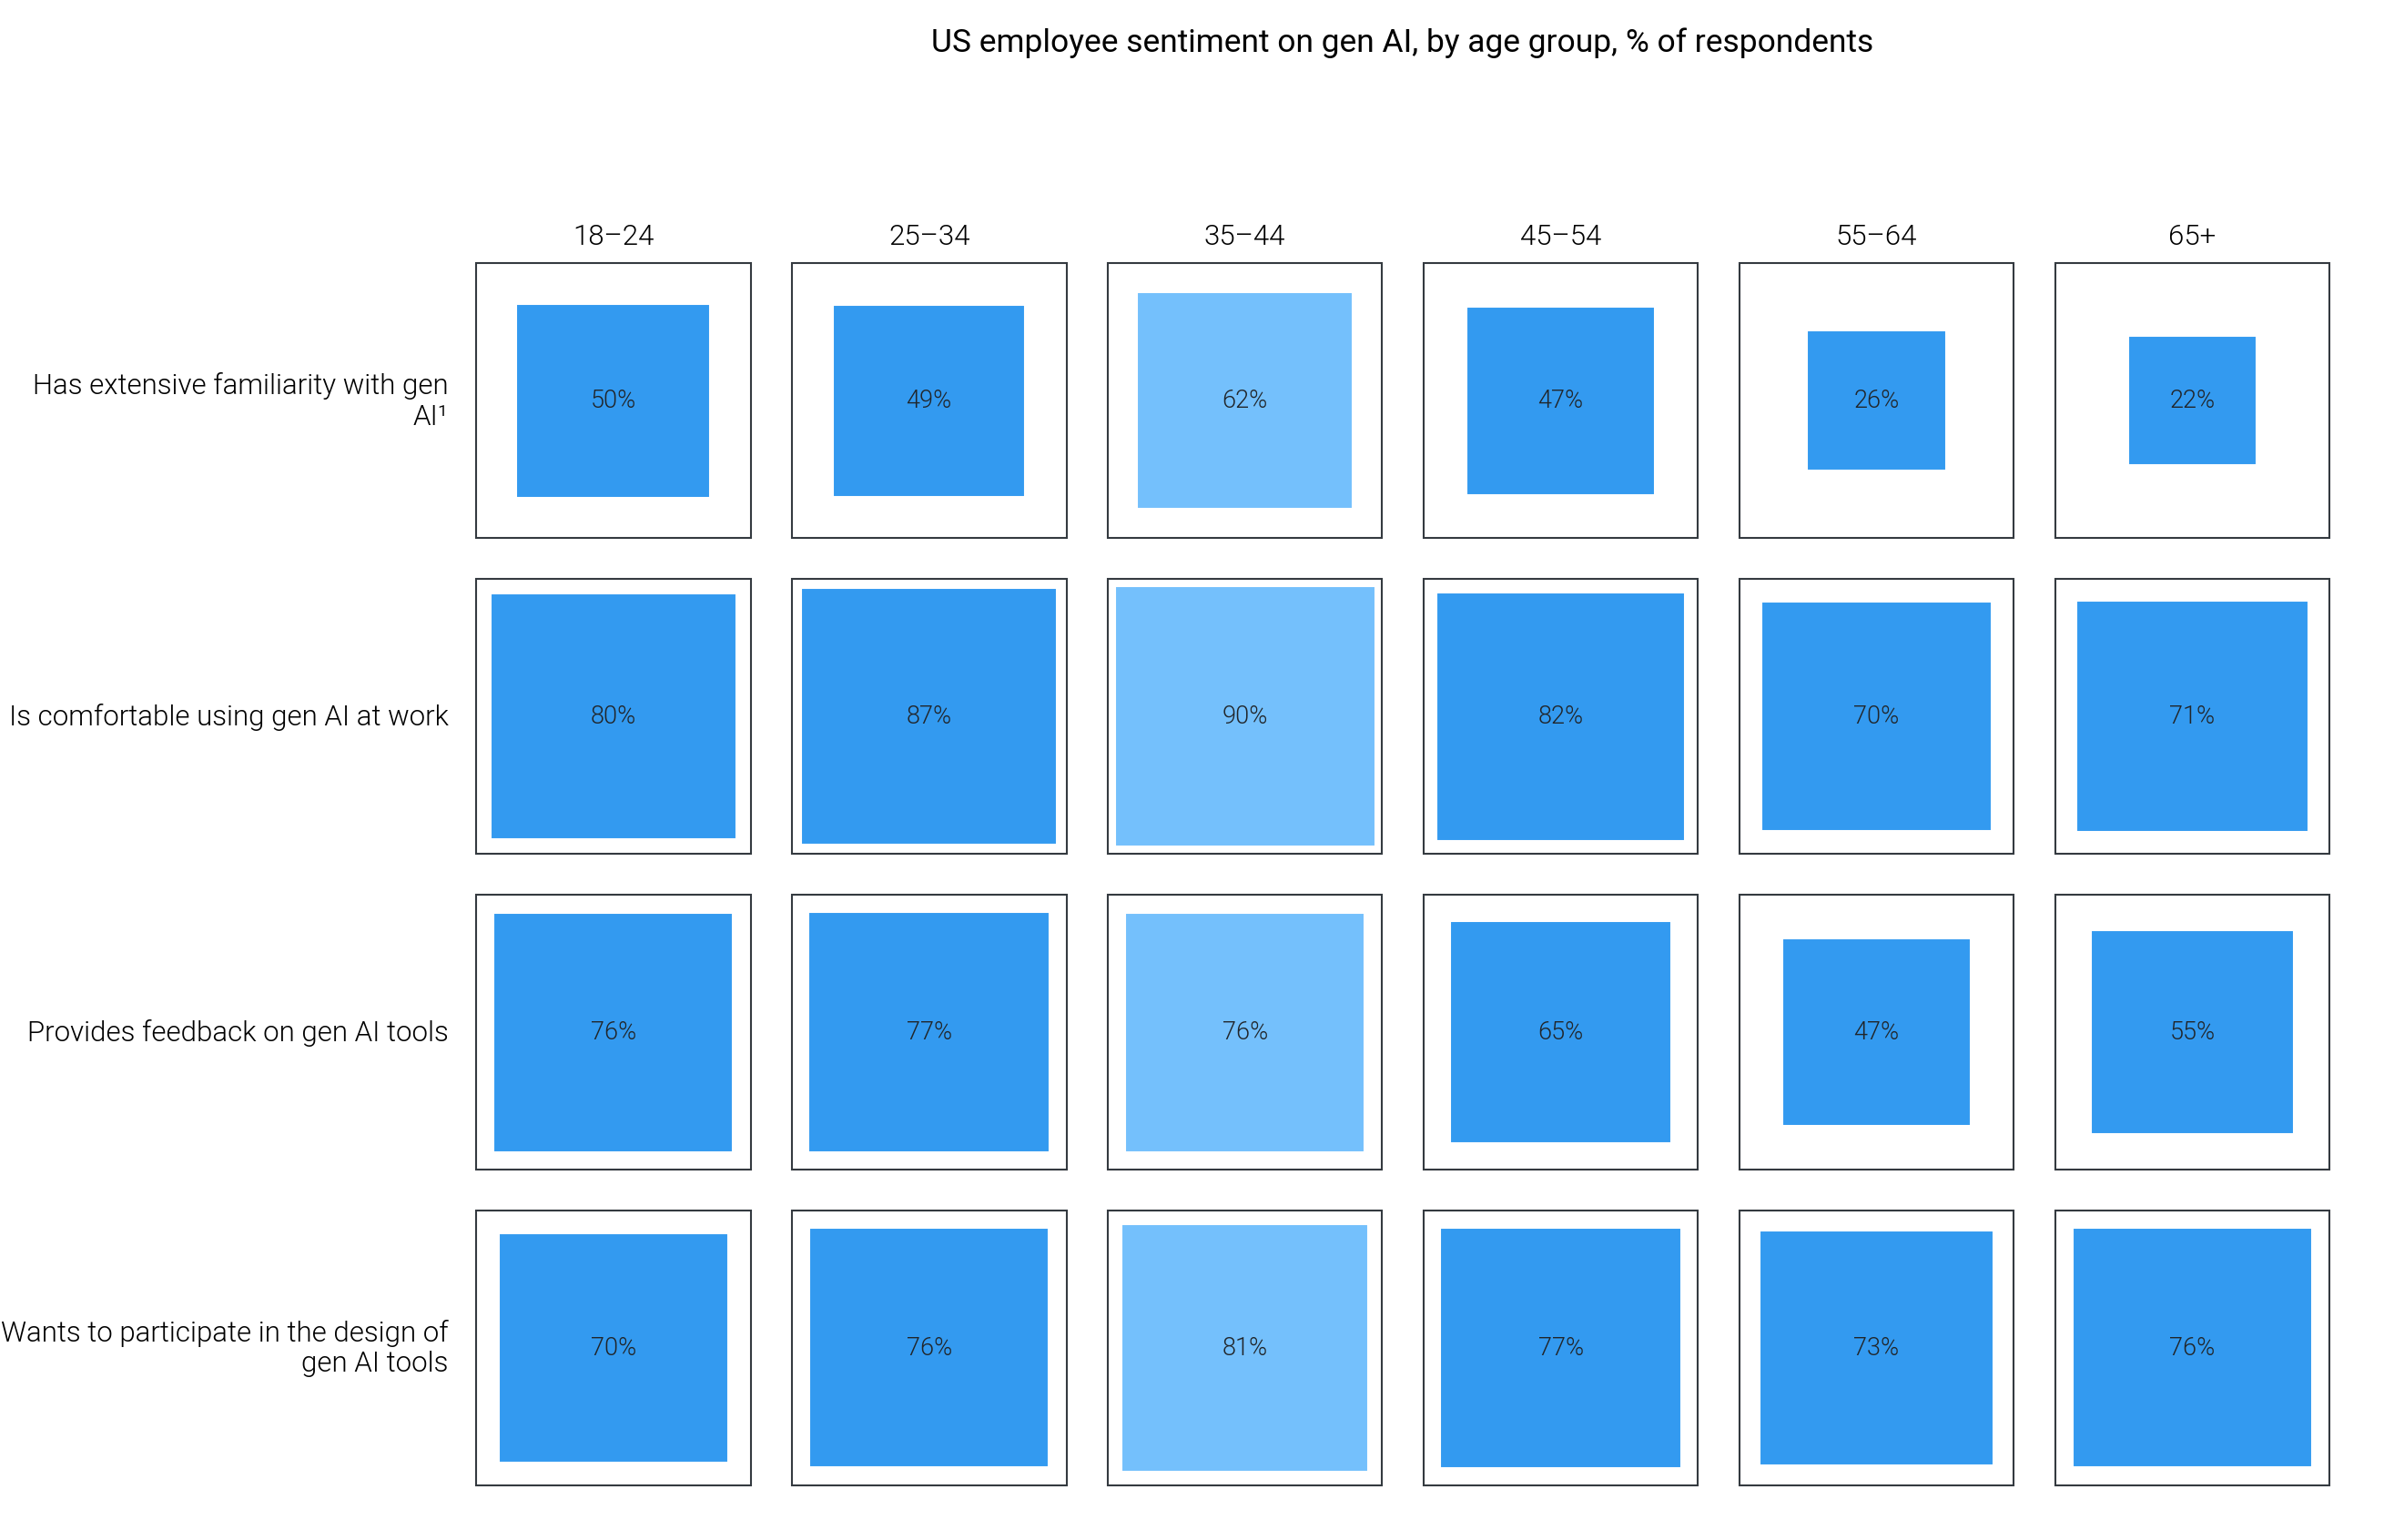

In [ ]:
# Data from the image: US employee sentiment on gen AI, by age group
# Each row represents a sentiment statement, each column represents an age group
# Values are percentages (0-100)

row_labels = [
    "Has extensive familiarity with gen AI¹",
    "Is comfortable using gen AI at work",
    "Provides feedback on gen AI tools",
    "Wants to participate in the design of gen AI tools"
]

col_labels = [
    "18–24",
    "25–34",
    "35–44",
    "45–54",
    "55–64",
    "65+"
]

# Data matrix: rows x columns
data = np.array([
    [50, 49, 62, 47, 26, 22],  # Has extensive familiarity
    [80, 87, 90, 82, 70, 71],  # Is comfortable using
    [76, 77, 76, 65, 47, 55],  # Provides feedback
    [70, 76, 81, 77, 73, 76],  # Wants to participate
])

# Highlight the 35-44 age group (column index 2)
highlight_cols = [2]

# Create the plot
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    colors={
        'default': 'dm.blue5',
        'highlight': 'dm.blue3'
    },
    title="US employee sentiment on gen AI, by age group, % of respondents"
)

dm.simple_layout(fig)
plt.show()


## Customization Examples

The function provides many parameters to customize the layout and appearance. Here are some examples:


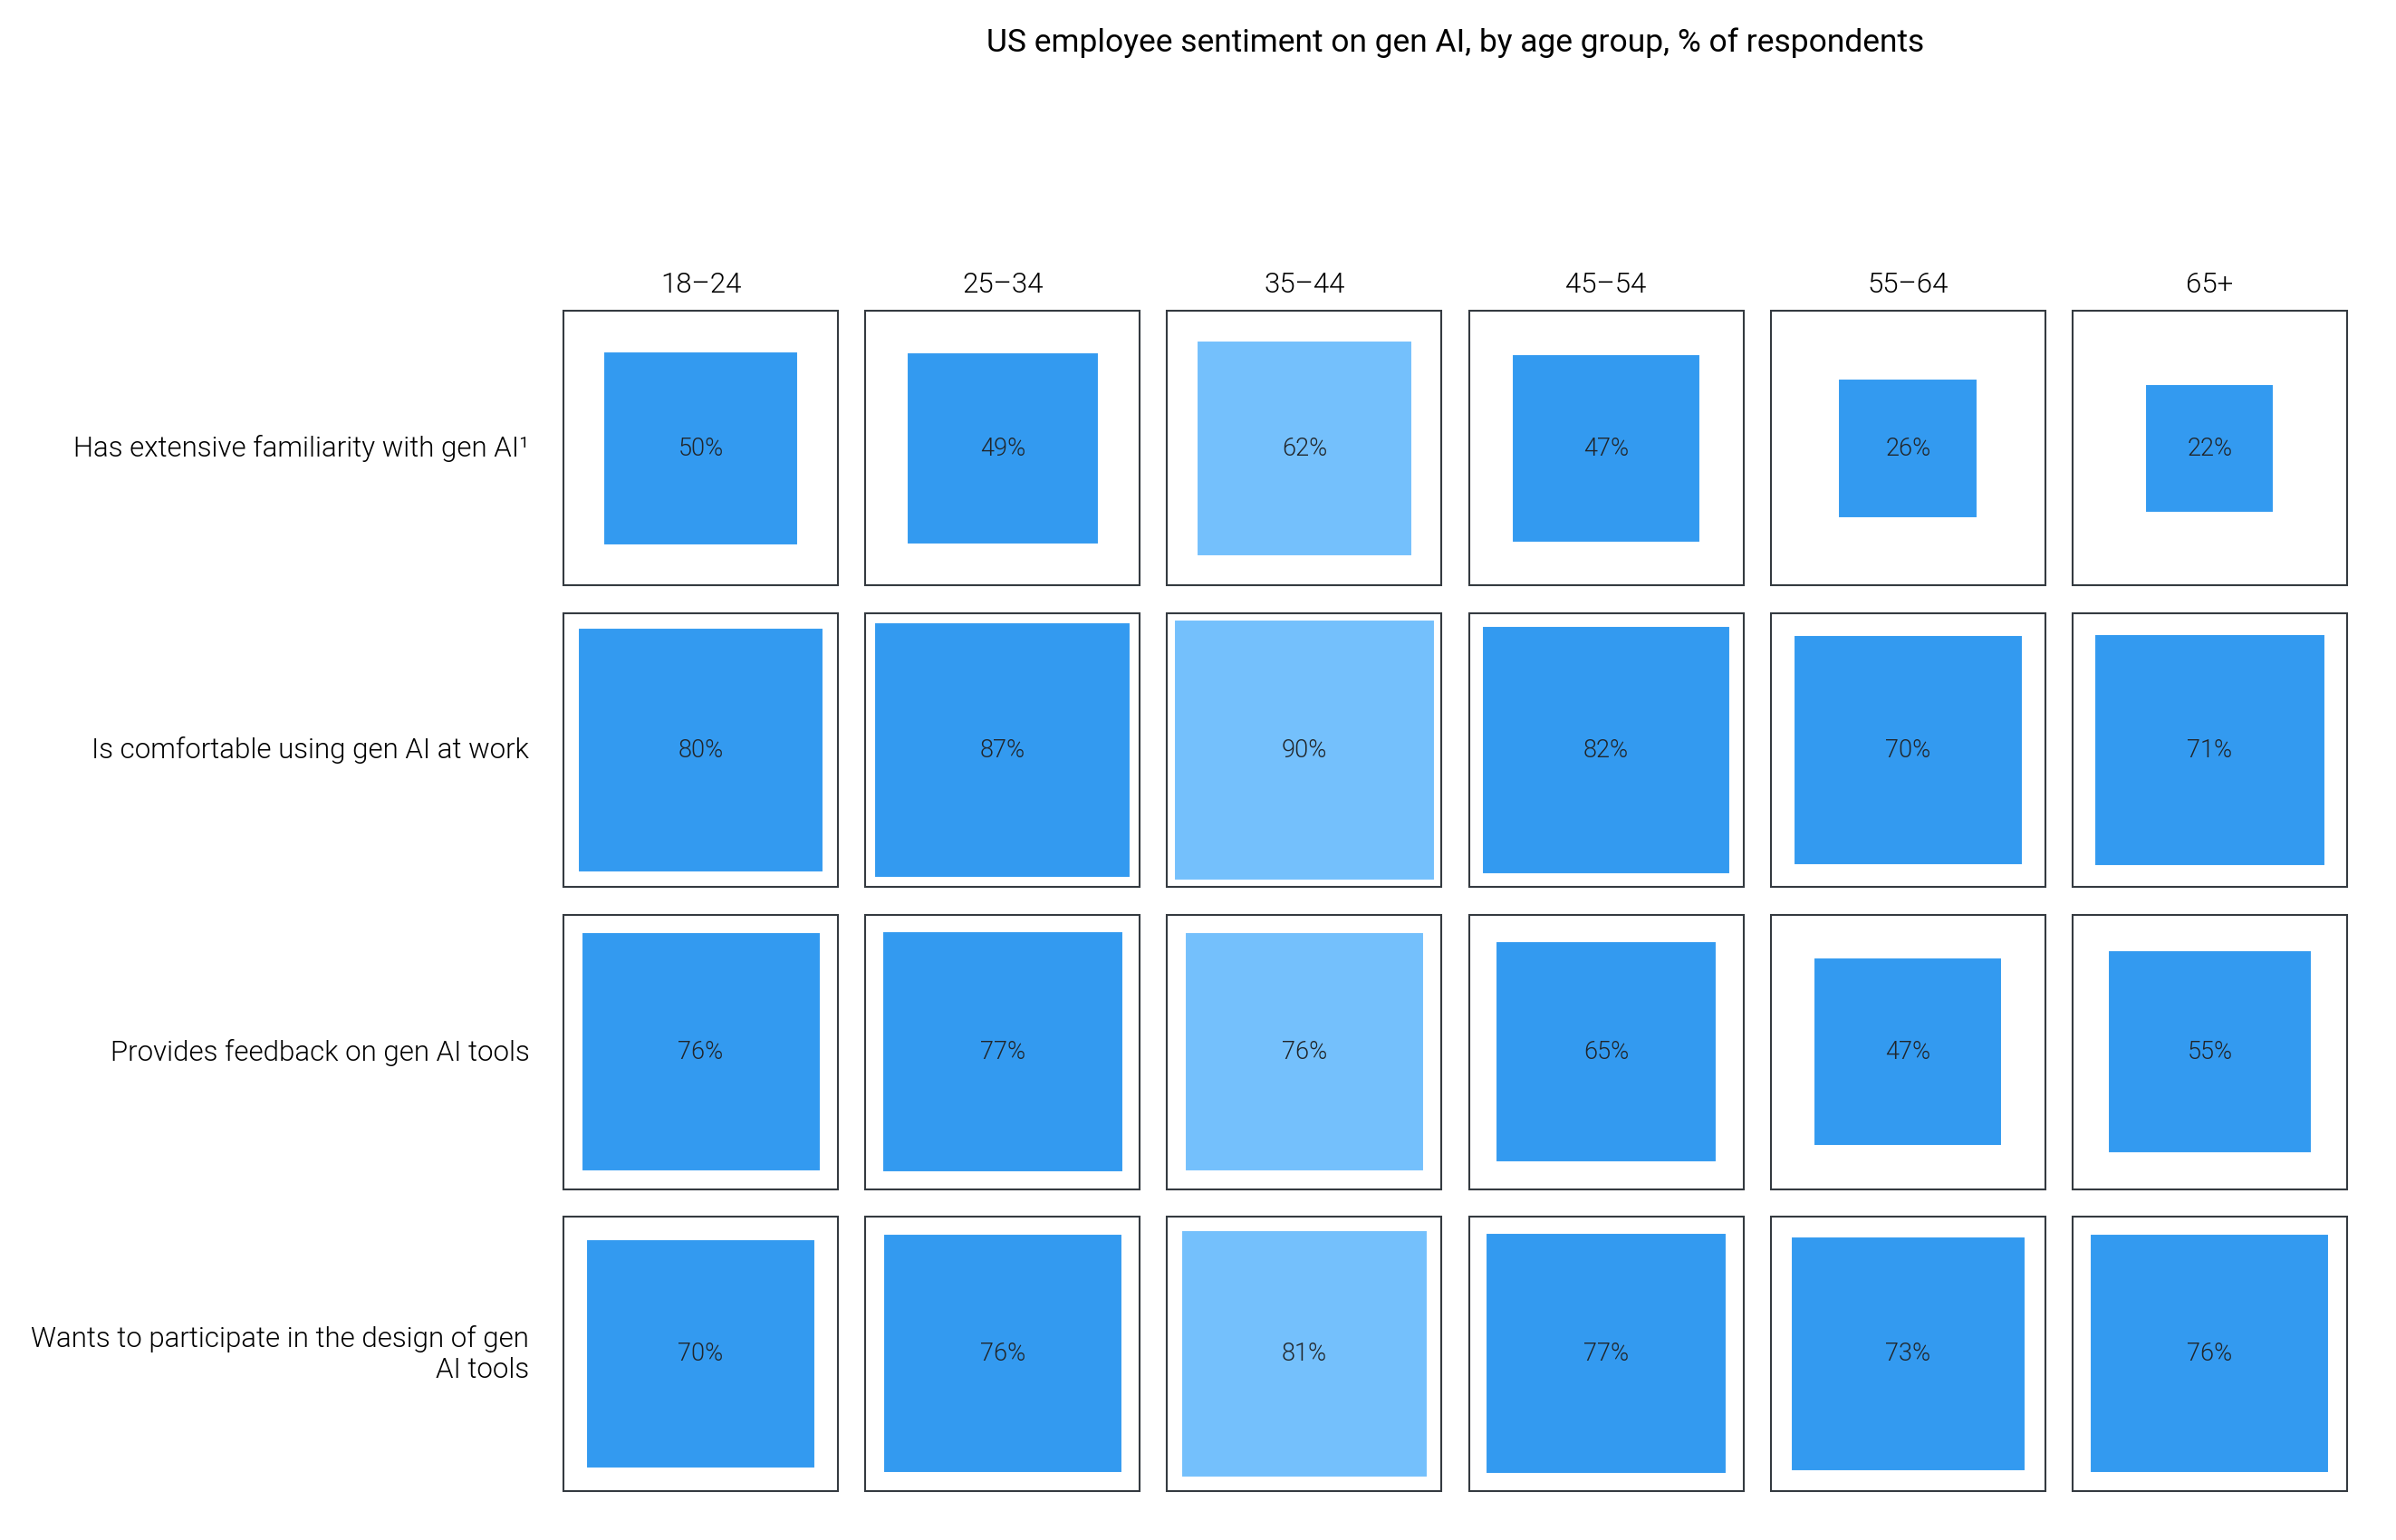

In [ ]:
# Example 1: Tighter spacing with smaller cells
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.3,        # Smaller cells
    cell_spacing=0.1,     # Tighter spacing
    margin=0.08,          # Smaller margins
    colors={
        'default': 'dm.blue5',
        'highlight': 'dm.blue3'
    },
    title="US employee sentiment on gen AI, by age group, % of respondents"
)

dm.simple_layout(fig)
plt.show()


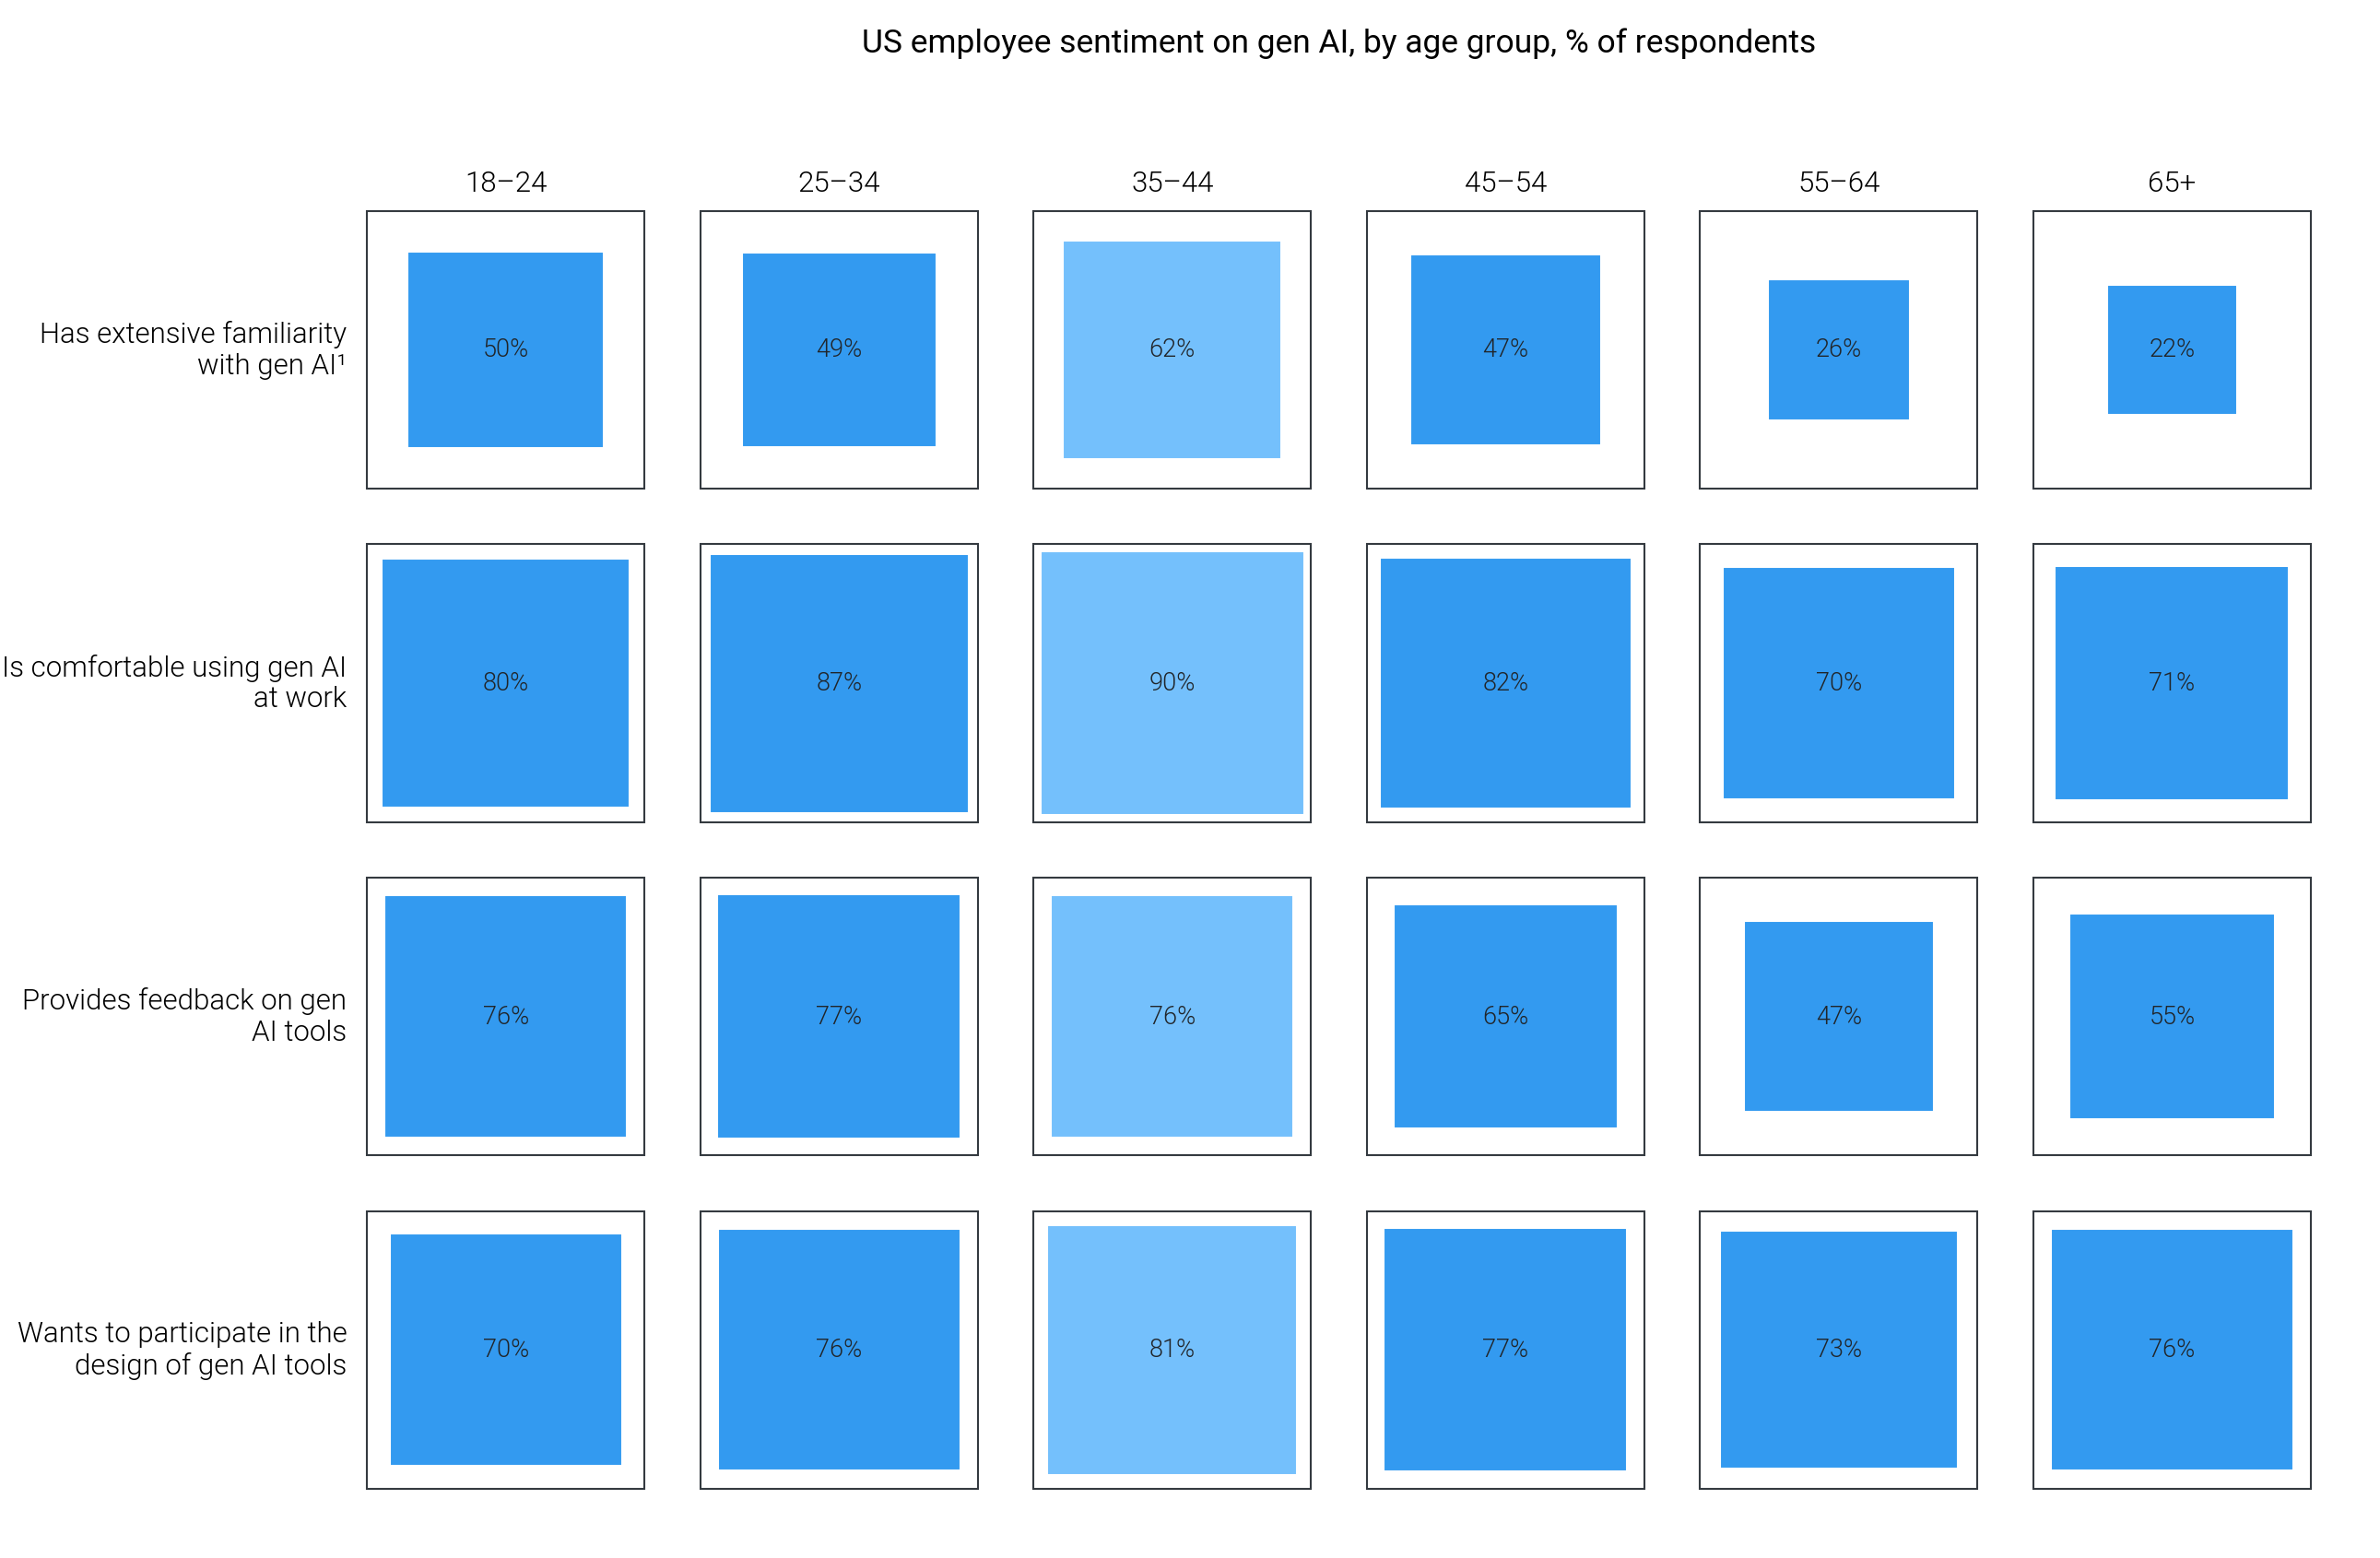

In [ ]:
# Example 2: Wider spacing with larger cells
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.6,        # Larger cells
    cell_spacing=0.2,     # Wider spacing
    margin=0.15,          # Larger margins
    colors={
        'default': 'dm.blue5',
        'highlight': 'dm.blue3'
    },
    title="US employee sentiment on gen AI, by age group, % of respondents"
)

dm.simple_layout(fig)
plt.show()


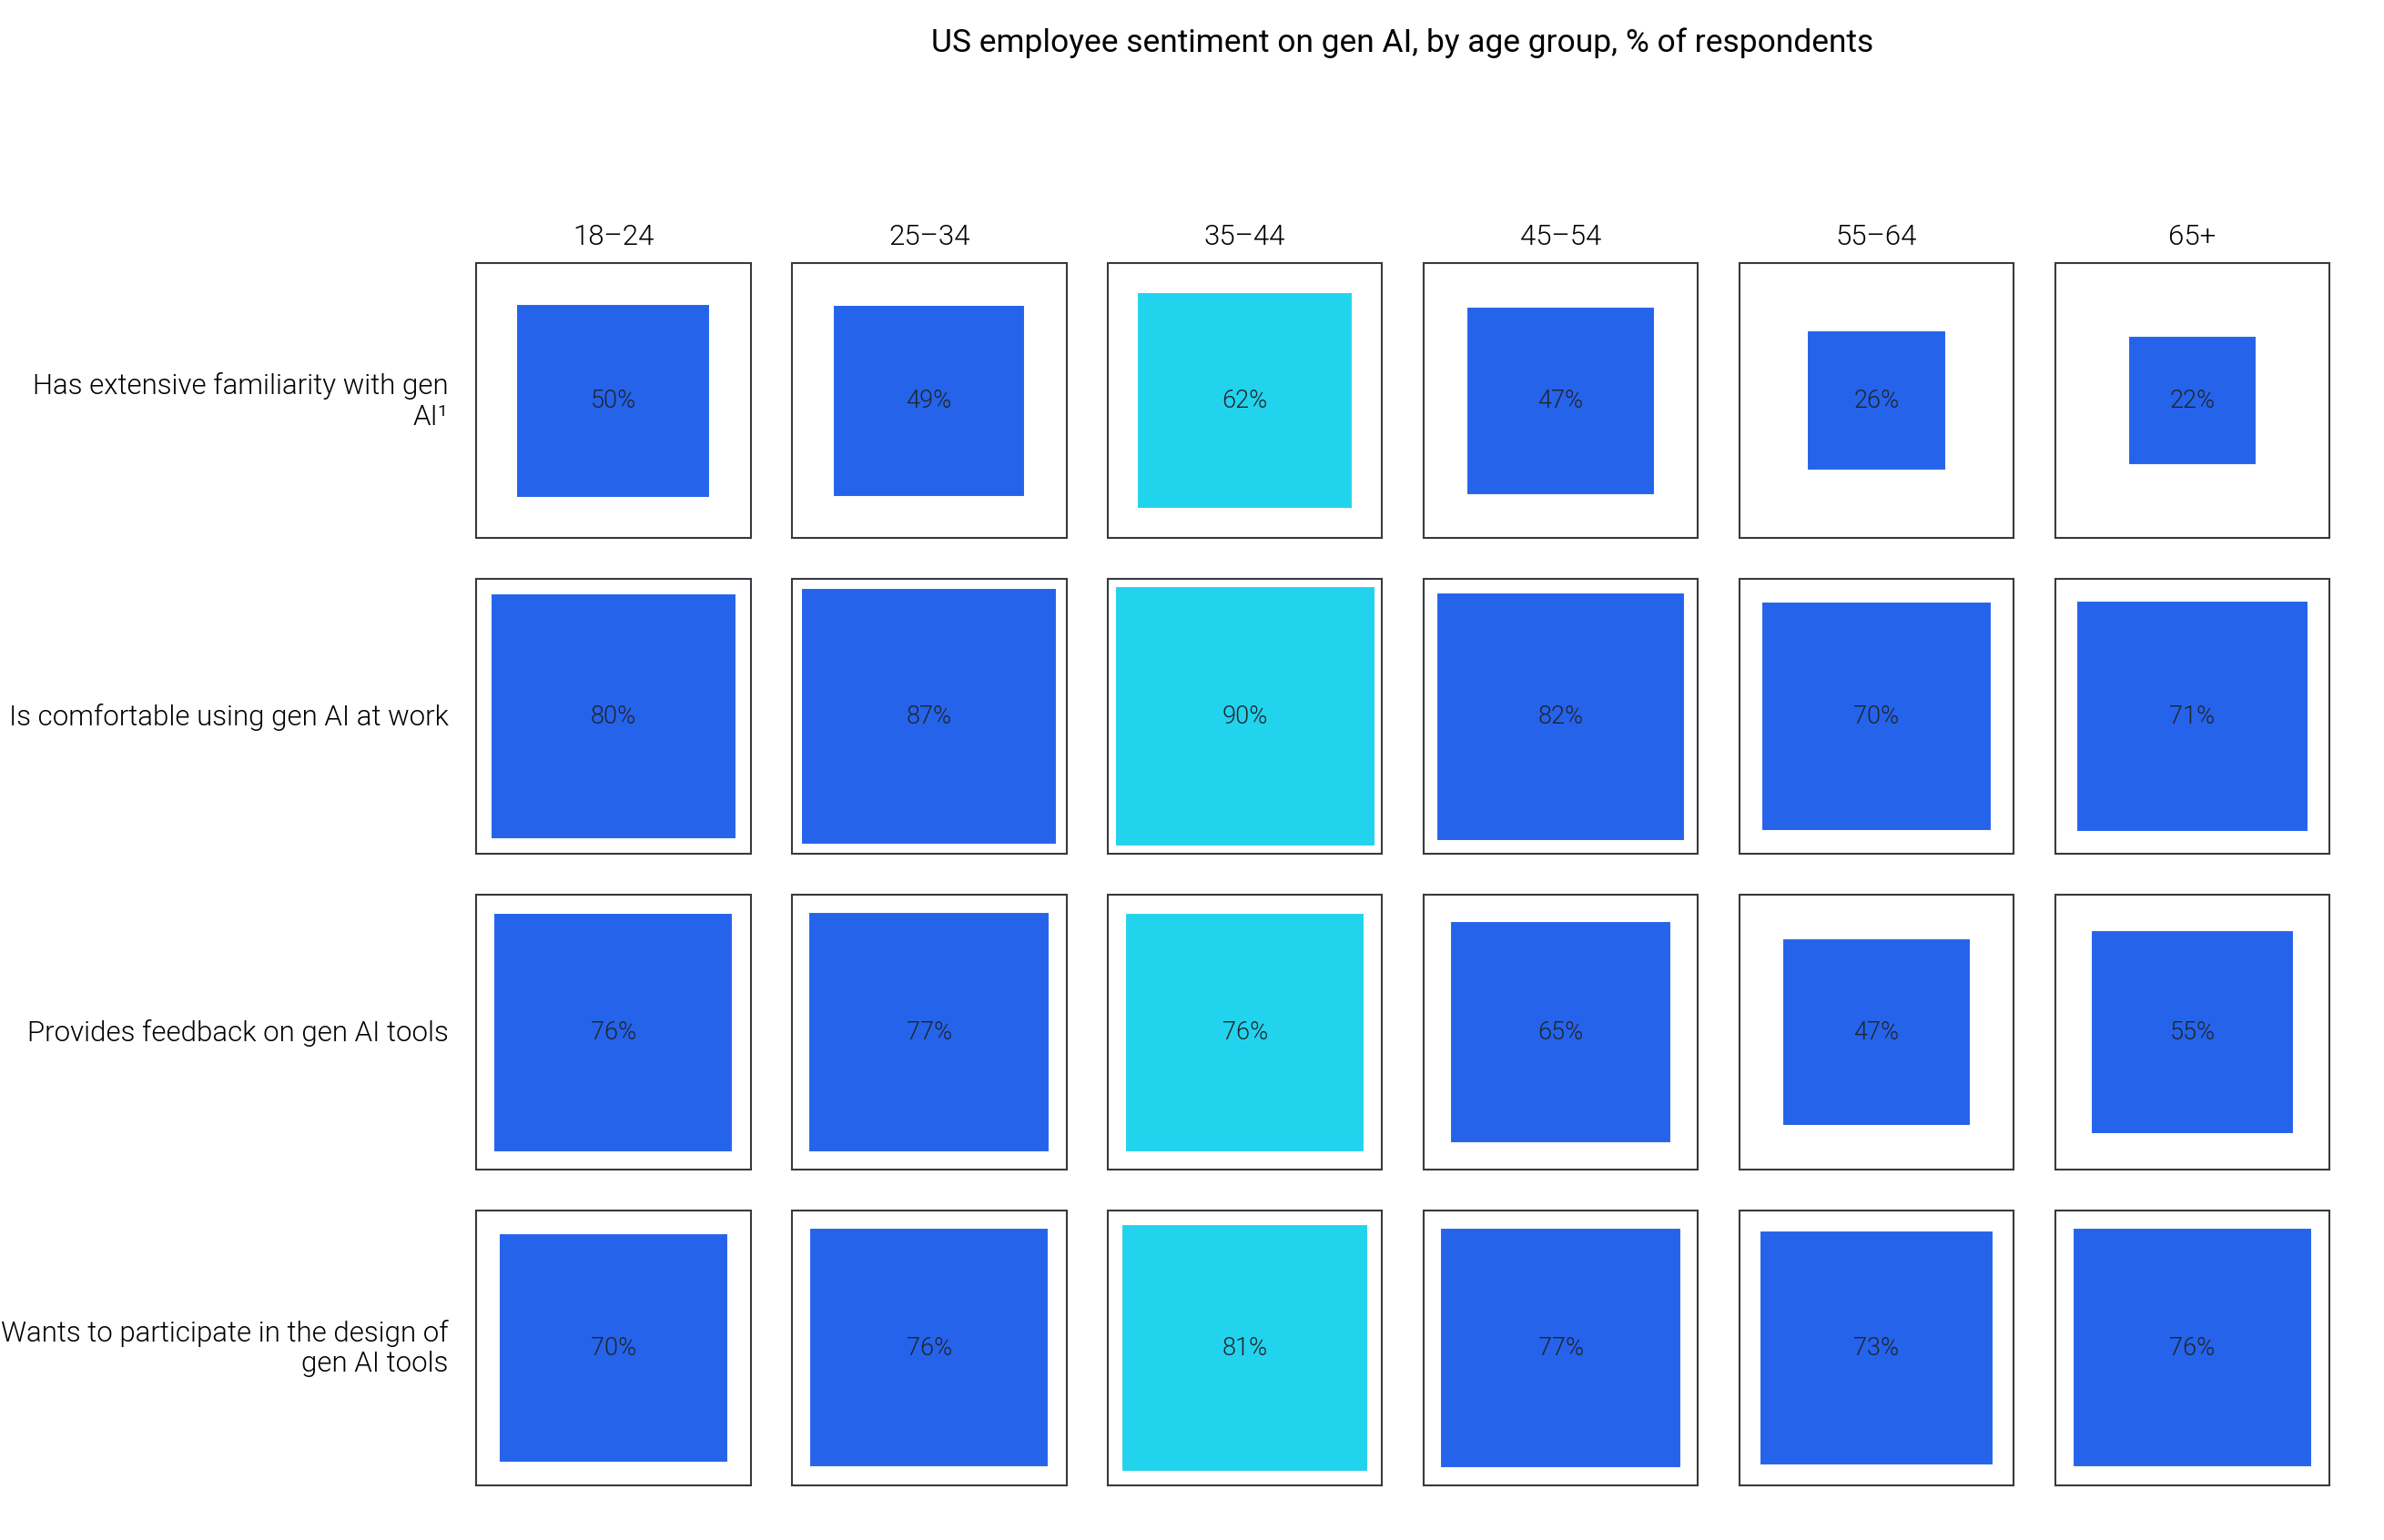

In [ ]:
# Example 3: Different color scheme
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    colors={
        'default': 'tw.blue:600',
        'highlight': 'tw.cyan:400'  # Lighter color for highlight
    },
    title="US employee sentiment on gen AI, by age group, % of respondents"
)

dm.simple_layout(fig)
plt.show()


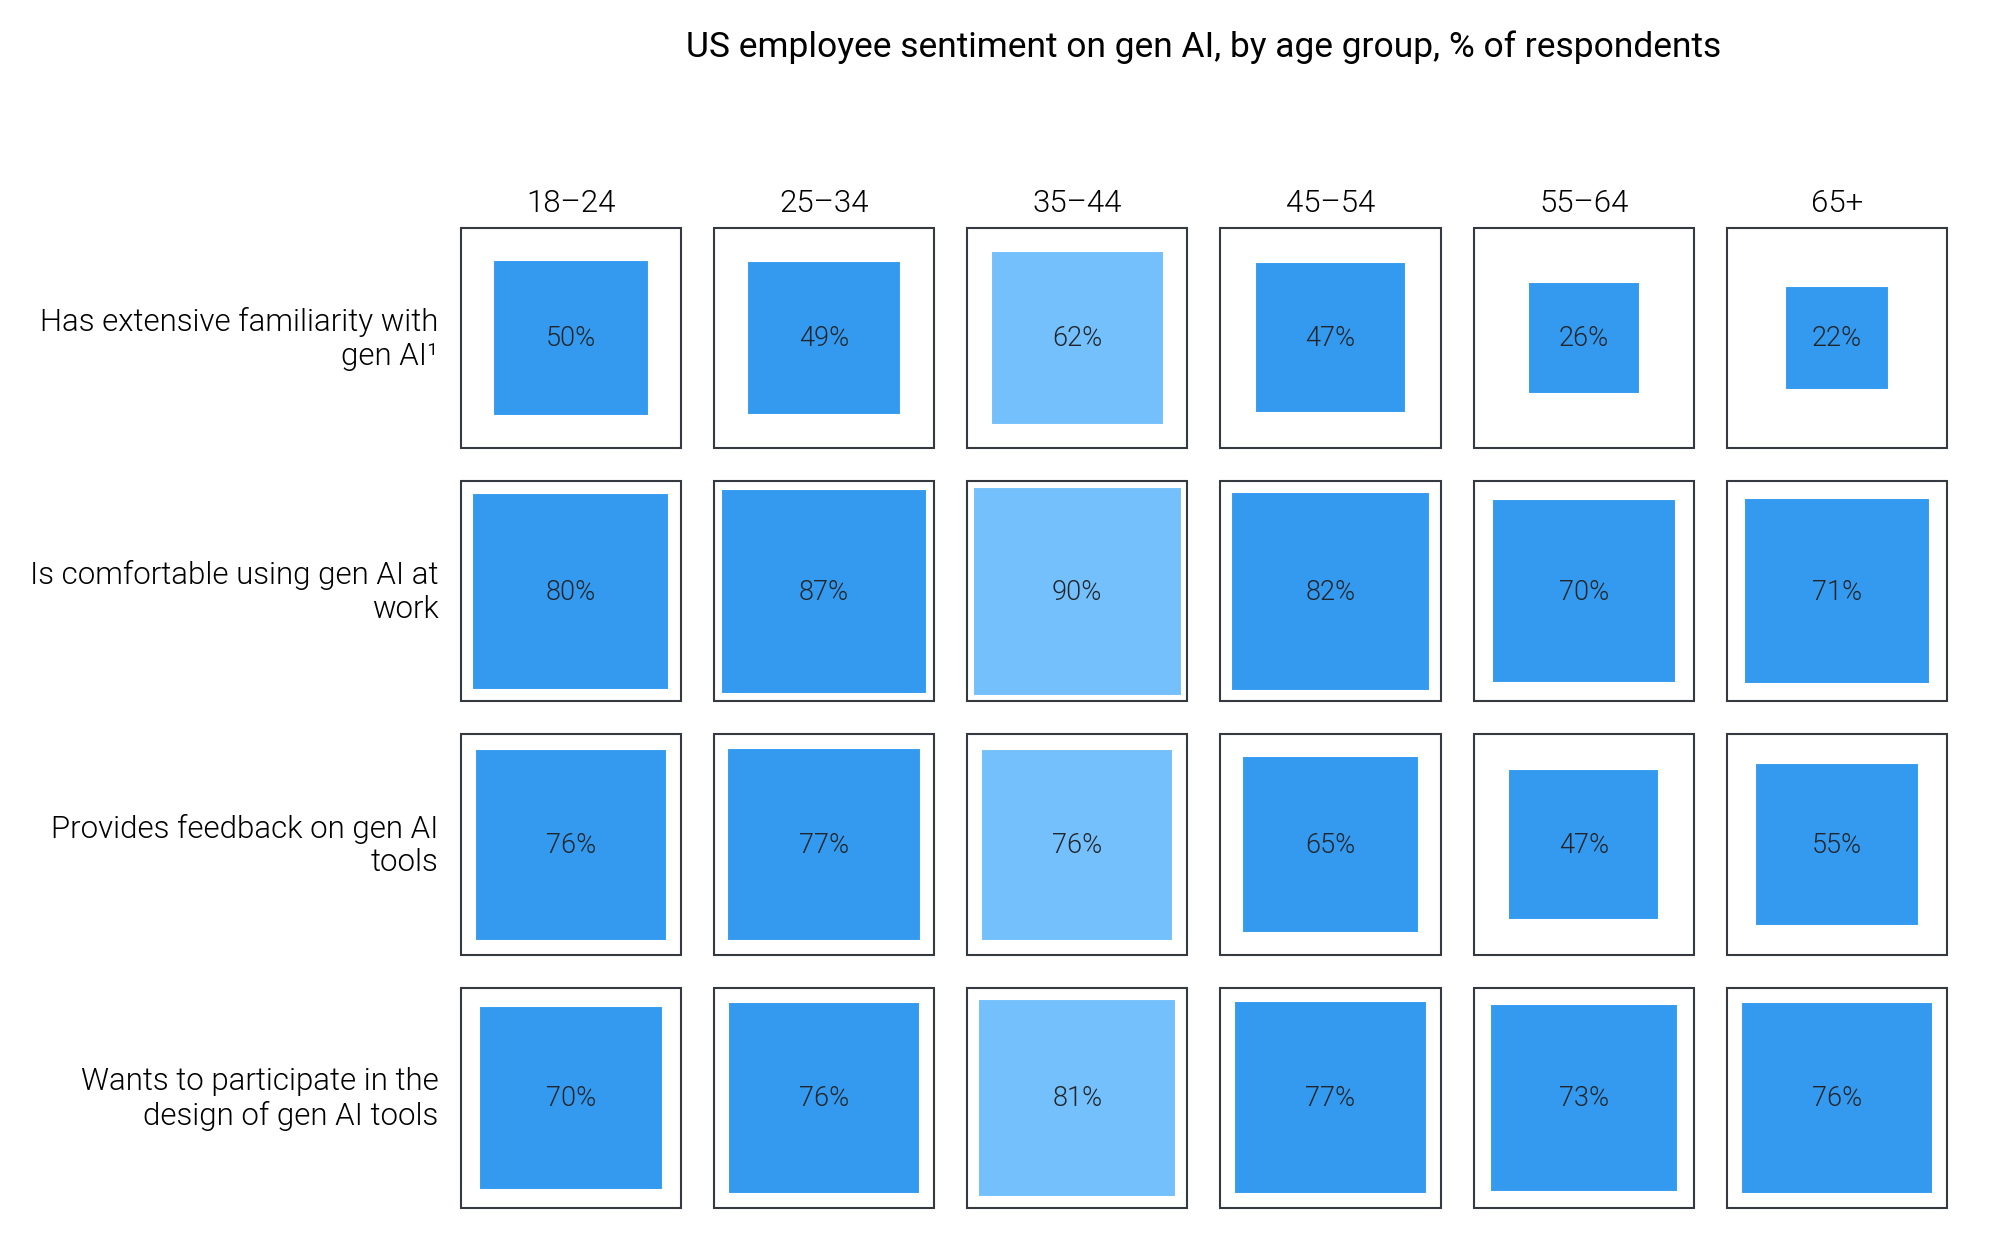

In [ ]:
# Example 4: Custom figure size
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    figsize=(dm.cm2in(18), dm.cm2in(10)),  # Custom figure size
    colors={
        'default': 'dm.blue5',
        'highlight': 'dm.blue3'
    },
    title="US employee sentiment on gen AI, by age group, % of respondents"
)

dm.simple_layout(fig)
plt.show()


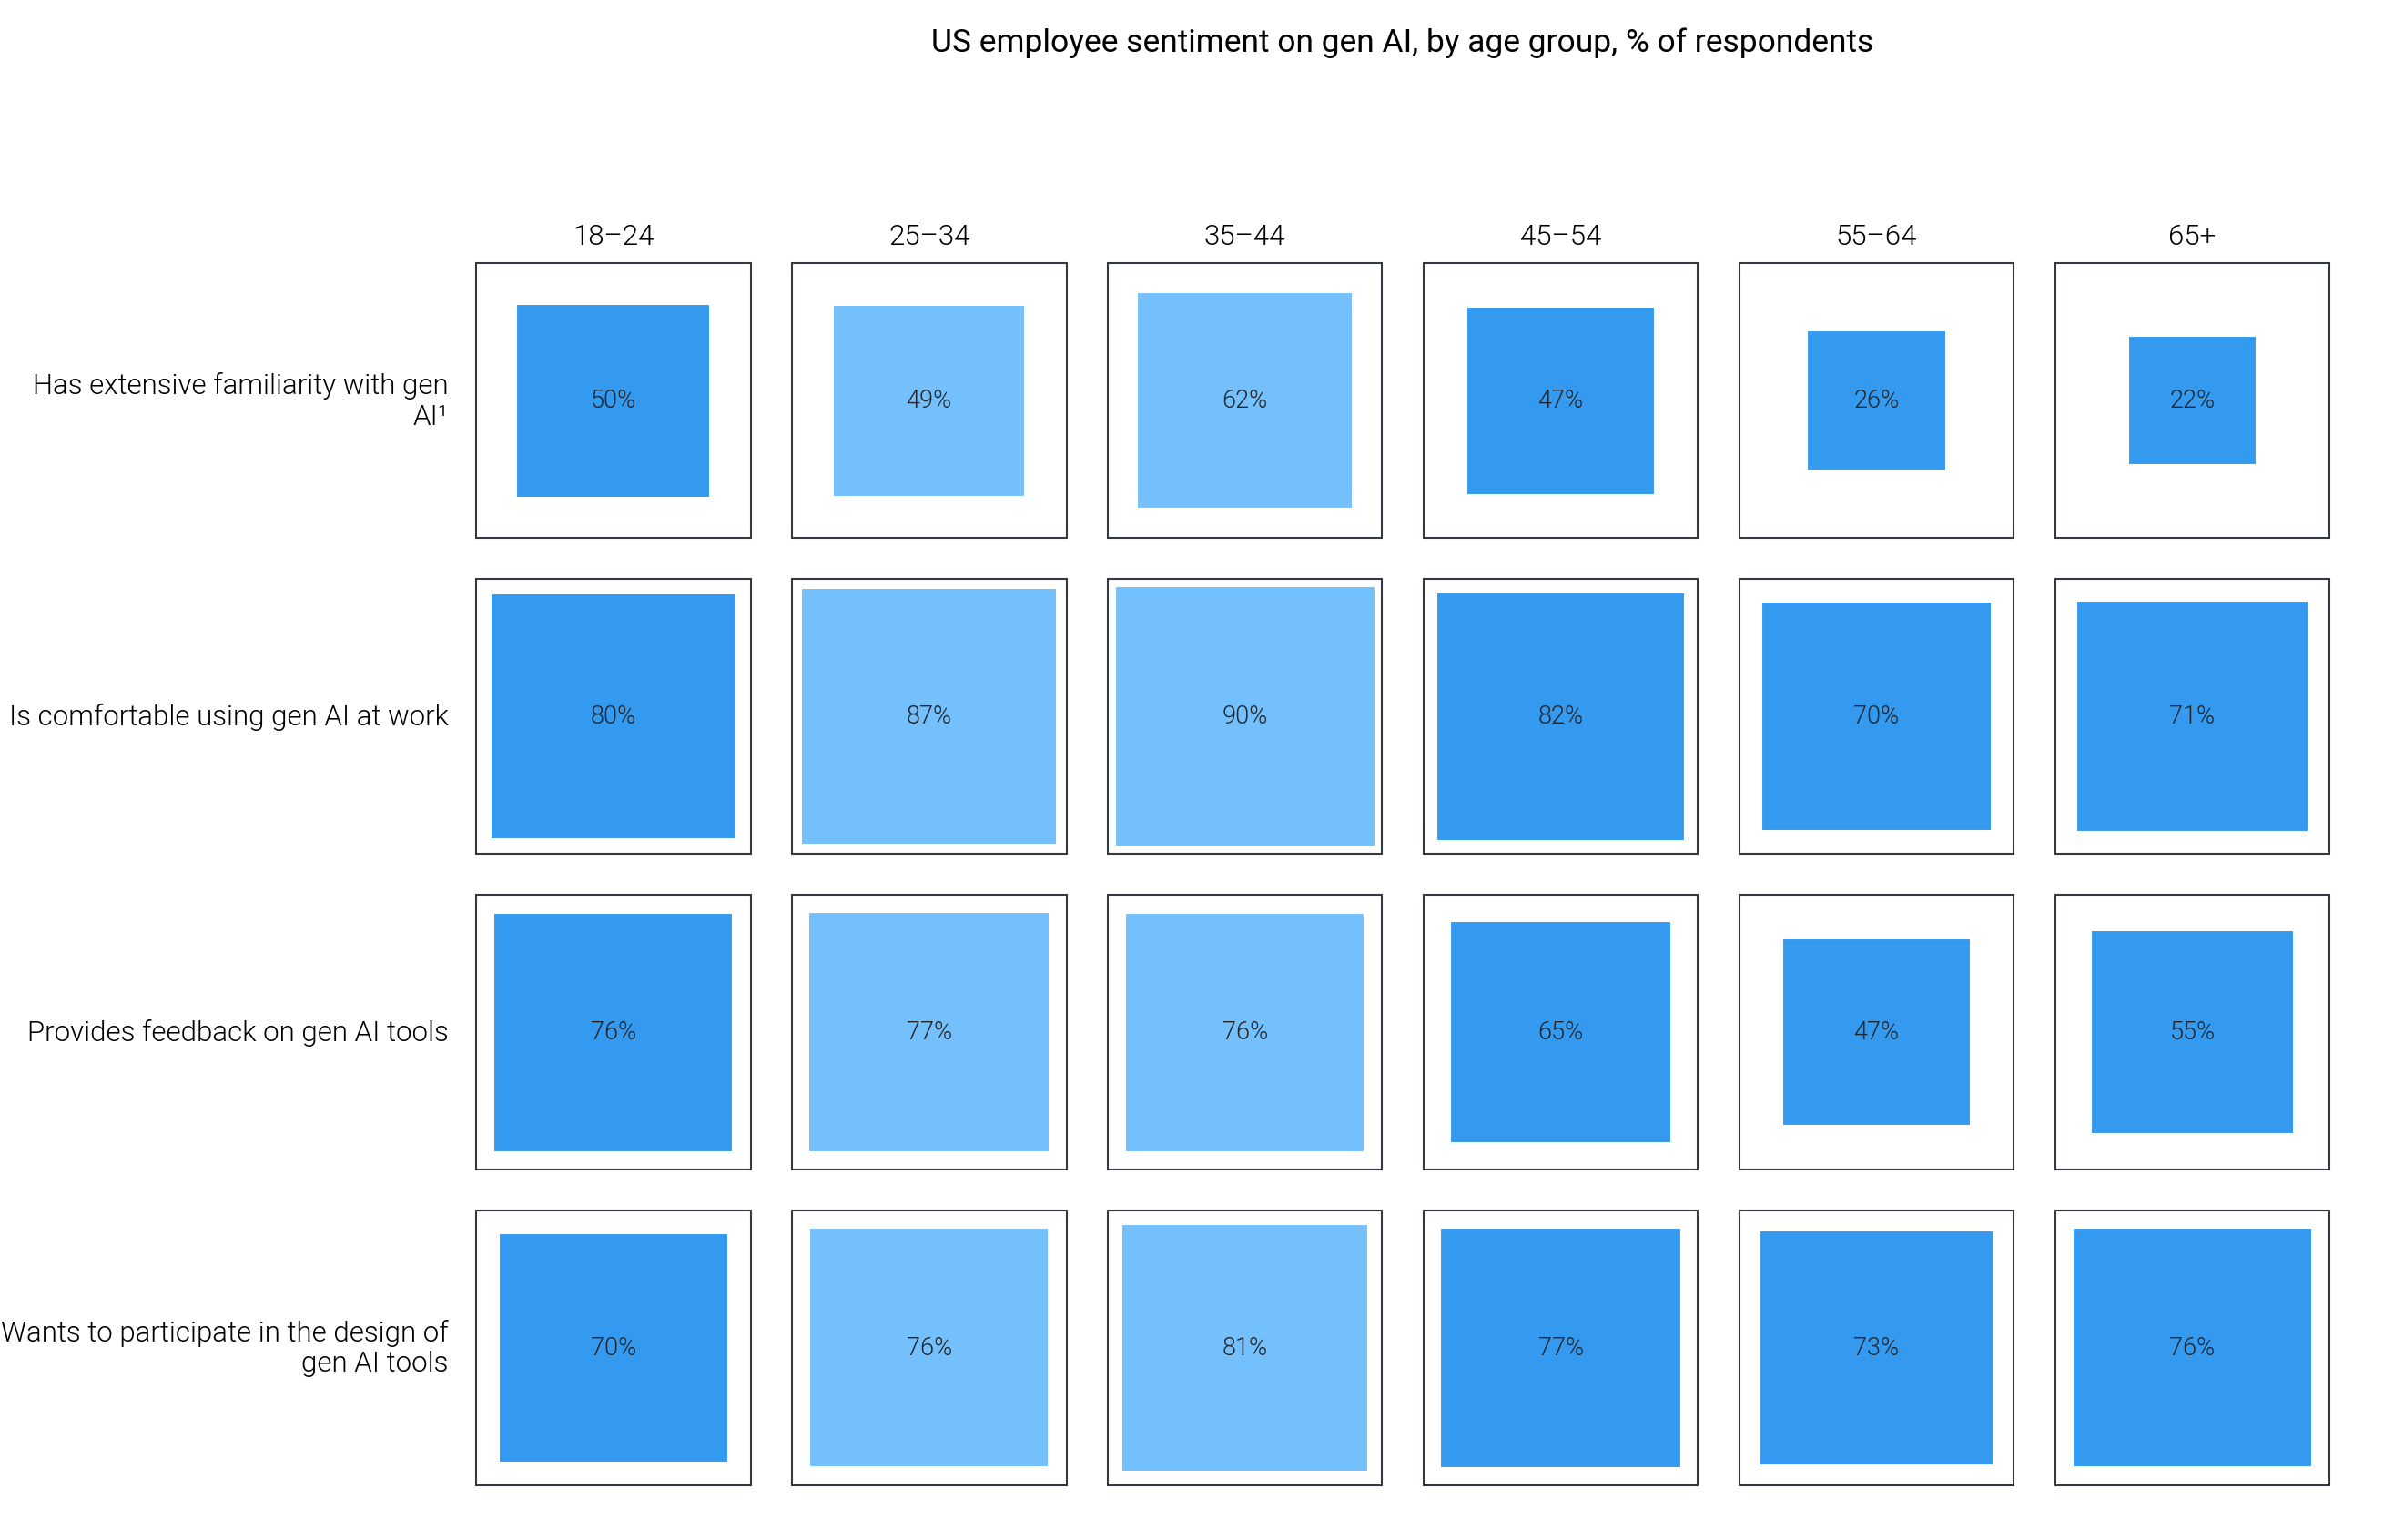

In [ ]:
# Example 5: Multiple highlighted columns
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=[1, 2],  # Highlight both 25-34 and 35-44
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    colors={
        'default': 'dm.blue5',
        'highlight': 'dm.blue3'
    },
    title="US employee sentiment on gen AI, by age group, % of respondents"
)

dm.simple_layout(fig)
plt.show()


## Parameter Reference

Key parameters for layout customization:

- **`cell_size`**: Base size of each cell (default: 1.0). Increase for larger cells.
- **`cell_spacing`**: Spacing between cells as fraction of cell_size (default: 0.15). Increase for more space between cells.
- **`margin`**: Margin around the entire grid as fraction of cell_size (default: 0.1). Increase for more white space.
- **`figsize`**: Tuple of (width, height) in inches. If None, calculated automatically.
- **`colors`**: Dictionary with 'default' and 'highlight' keys for color specifications.
- **`highlight_cols`**: List of column indices to highlight (0-indexed).
